In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma

In [7]:
def convertDate(d):
    date = datetime.datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p')
    return datetime.date(date.year, date.month, date.day)

In [8]:
complaints = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', converters={'Created Date': convertDate})

In [4]:
complaints.columns

Index([u'Unique Key', u'Created Date', u'Complaint Type', u'Descriptor'], dtype='object')

In [9]:
complaints.iloc[0]

Unique Key                  31901130
Created Date              2015-11-04
Complaint Type    Noise - Commercial
Descriptor          Loud Music/Party
Name: 0, dtype: object

In [11]:
groups = complaints.groupby('Created Date')

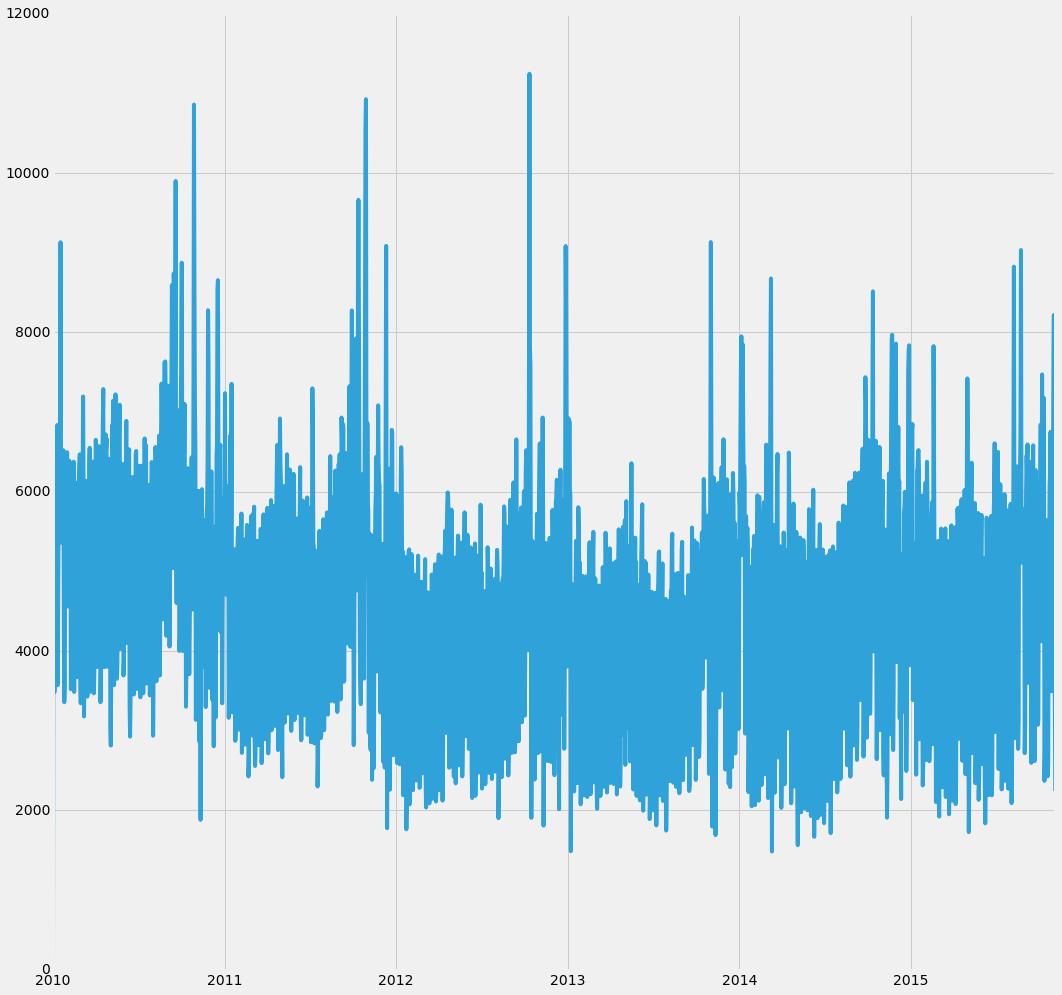

In [15]:
figure, ax = pl.subplots(figsize=(16,16))
ax.plot(complaints['Created Date'].unique(), groups.count()['Unique Key'])

In [24]:
cycle, trend = sma.tsa.filters.hpfilter(groups.count()['Unique Key'], lamb = 129600)

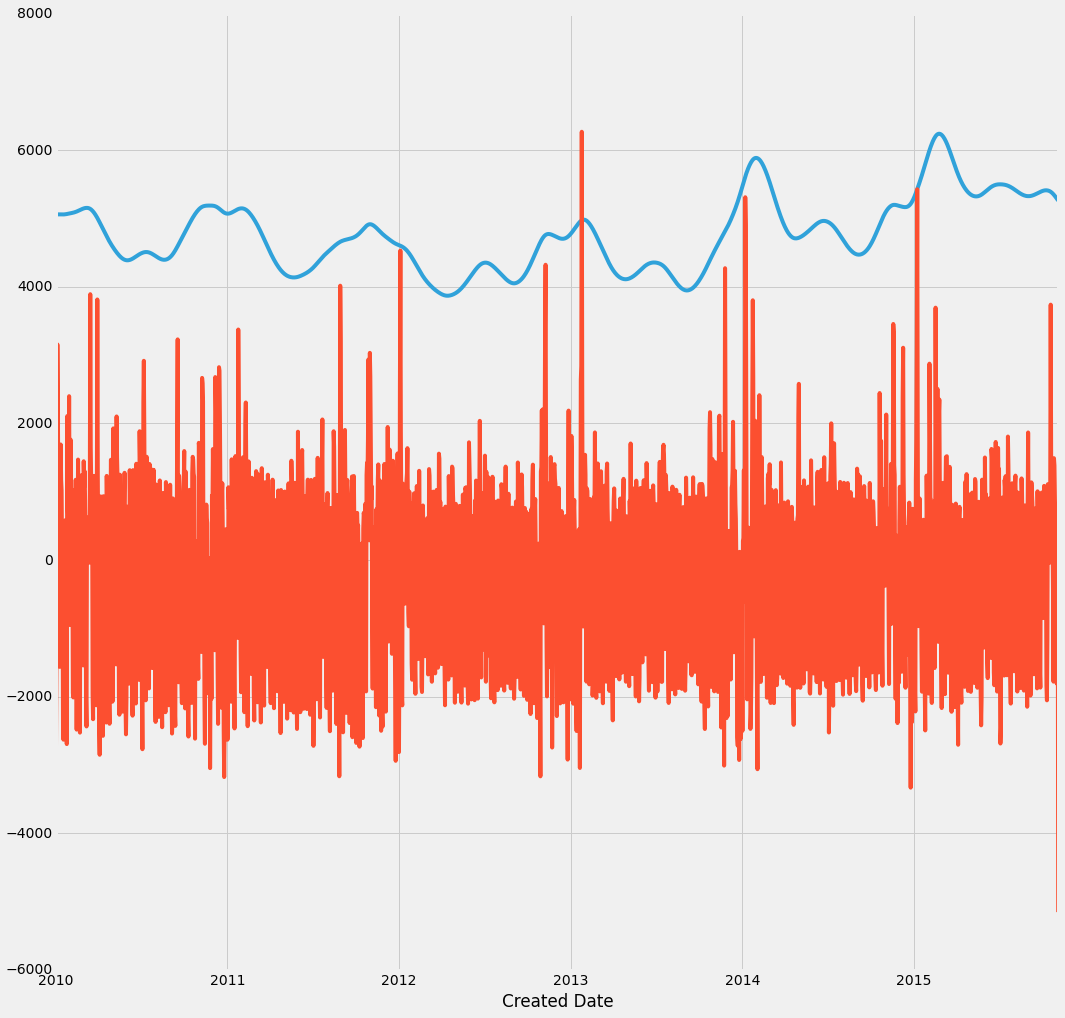

In [26]:
figure, ax = pl.subplots(figsize=(16,16))
trend.plot()
cycle.plot()

In [30]:
complaints.iloc[0]['Created Date'].weekday()

2

In [32]:
complaints['dow'] = complaints.apply(lambda x: x['Created Date'].weekday(), axis=1)

In [33]:
groups = complaints.groupby('Created Date')

In [37]:
d = {
    'dow': groups.mean()['dow'],
    'count': groups.count()['dow'],
    'date': complaints['Created Date'].unique()
}

mod = smf.ols(formula='count ~ C(dow)', data = d).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     472.8
Date:                Thu, 05 Nov 2015   Prob (F-statistic):               0.00
Time:                        16:15:16   Log-Likelihood:                -17665.
No. Observations:                2134   AIC:                         3.534e+04
Df Residuals:                    2127   BIC:                         3.538e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    5503.5902     54.613    100.774      

In [38]:
def convertStreak(streak):
    # N is post season?
    if streak == "N":
        return float('Nan')
    sign = -1 if streak[0] == "-" else 1
    return len(streak) * sign

def getDateConverter(year):
    def convertDate(date):
        # Handle duplicate headers
        if date == 'Date':
            return None
        
        # Remove double-header indication (1), (2) and convert to date
        d = datetime.datetime.strptime(re.sub(r'\s\(.*\)', '', date) + ' ' + str(year), '%A %b %d %Y')
        #d.year = year
        return datetime.date(d.year, d.month, d.day)
    
    return convertDate

def convertWL(wl):
    # Covert the W/L column to numeric
    if wl and wl[0] == 'W':
        return 1
    return 0

def readGameLog(csv, convertDate):
    df = pd.read_csv(csv, skip_blank_lines=True, converters={'Streak': convertStreak, 'Date': convertDate, 'W/L': convertWL})
    
    # Remove the headers in the middle of the file and postseason
    df = df.drop(df.index[
        (df.Rk == "Rk") | # Drop header rows
        np.isnan(df.Streak) # Post Season
    ])
    
    #print [d.days for d in np.diff(df.Date)]
    
    # First game in double headers
    df = df.drop(df.index[(np.append([d.days for d in np.diff(df.Date)], [1]) == 0)])
    
    return df

In [41]:
dfs = []
years = range(2010,2016)
for year in years:
    dfs.append(readGameLog("teams_NYM_%s-schedule-scores_team_schedule.csv" % str(year), getDateConverter(year)))
    
baseball = pd.concat(dfs, ignore_index=True)

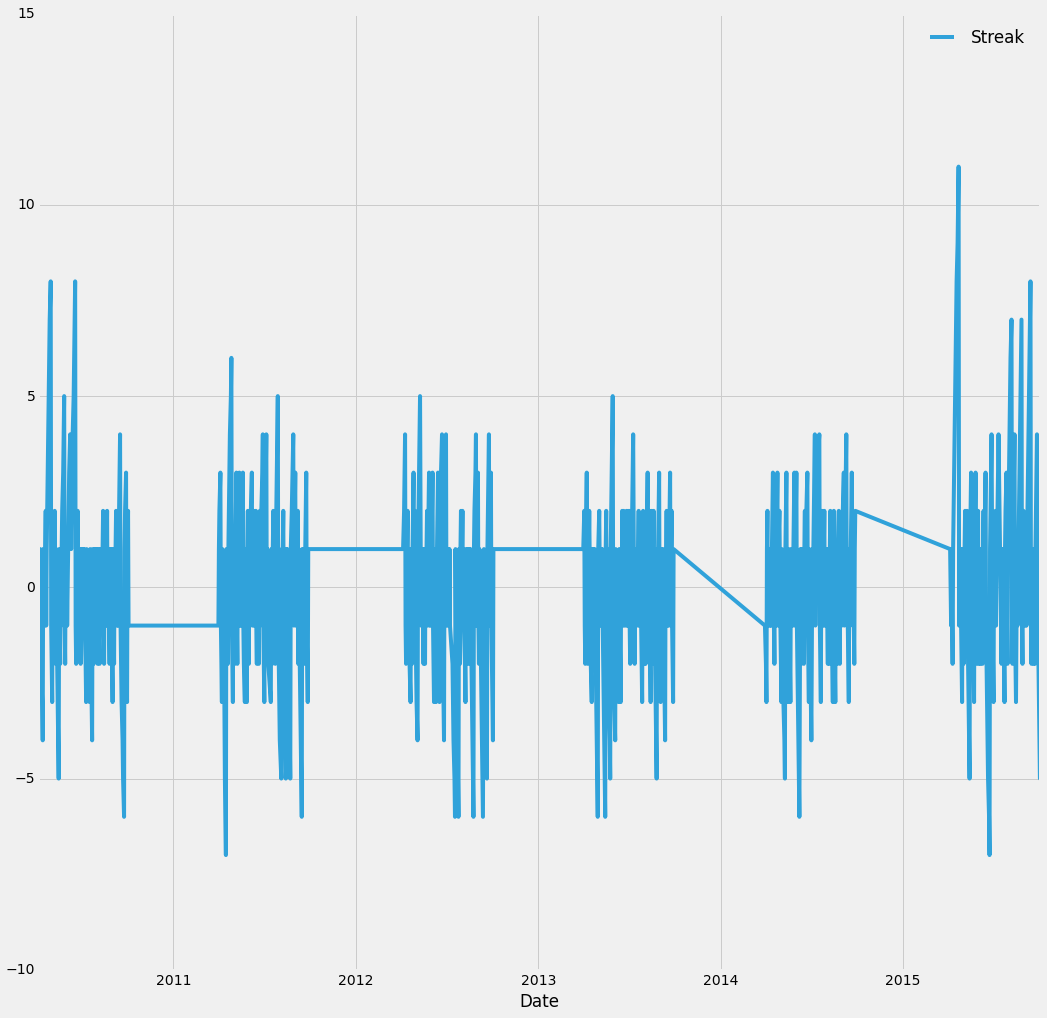

In [42]:
baseball.plot('Date', 'Streak', figsize=(16,16))

In [43]:
complaints = complaints.rename(columns = {'Created Date': 'Date'})

In [45]:
merged = pd.merge(baseball, complaints, on='Date')

In [46]:
grouped = merged.groupby('Date')

In [51]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.723
Date:                Thu, 05 Nov 2015   Prob (F-statistic):             0.0992
Time:                        16:26:18   Log-Likelihood:                -8244.9
No. Observations:                 956   AIC:                         1.649e+04
Df Residuals:                     954   BIC:                         1.650e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4435.1205     43.607    101.706      0.0

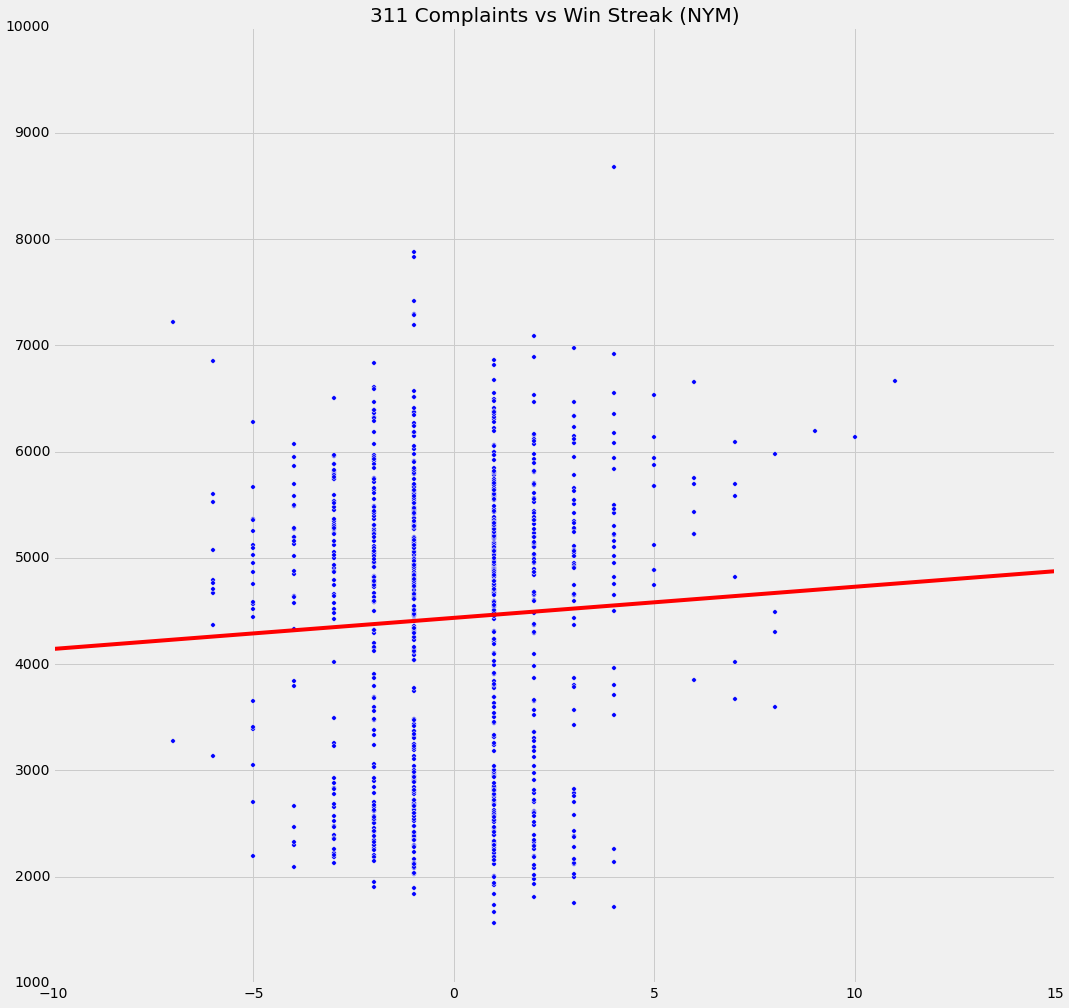

In [52]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('311 Complaints vs Win Streak (NYM)')

In [53]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     361.8
Date:                Thu, 05 Nov 2015   Prob (F-statistic):          1.28e-262
Time:                        16:26:53   Log-Likelihood:                -7624.6
No. Observations:                 956   AIC:                         1.527e+04
Df Residuals:                     948   BIC:                         1.530e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5127.2916     70.338     72.895      0.0

In [60]:
noise = merged[merged['Complaint Type'].str.contains('Noise')]

In [64]:
grouped = noise.groupby('Date')

In [65]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.450
Date:                Thu, 05 Nov 2015   Prob (F-statistic):              0.229
Time:                        16:33:39   Log-Likelihood:                -6330.6
No. Observations:                 956   AIC:                         1.267e+04
Df Residuals:                     954   BIC:                         1.267e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    409.0964      5.887     69.491      0.0

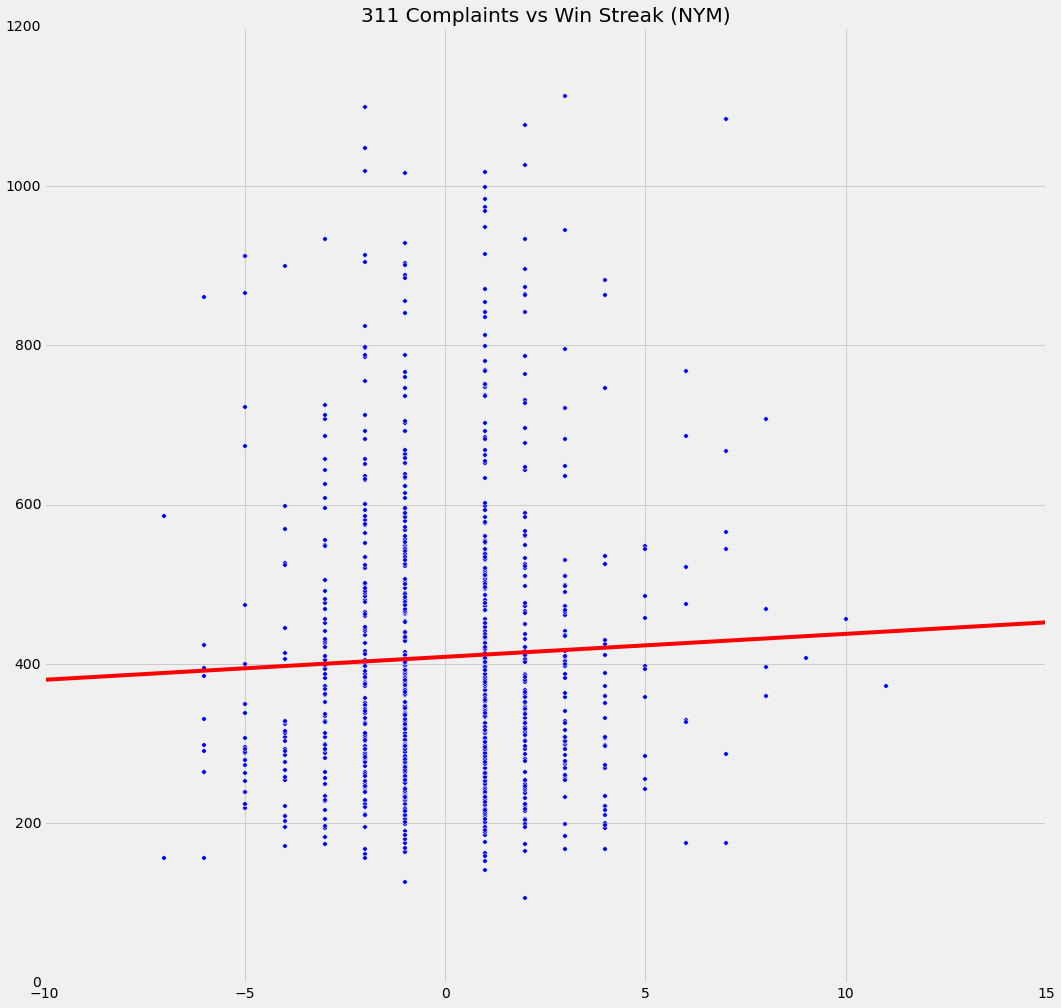

In [66]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('311 Complaints vs Win Streak (NYM)')

In [67]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     43.69
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           1.22e-53
Time:                        16:33:50   Log-Likelihood:                -6197.6
No. Observations:                 956   AIC:                         1.241e+04
Df Residuals:                     948   BIC:                         1.245e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    347.2209     15.810     21.962      0.0

In [68]:
wonoise = merged[~merged['Complaint Type'].str.contains('Noise')]

In [69]:
grouped = wonoise.groupby('Date')

In [70]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

In [71]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     458.0
Date:                Thu, 05 Nov 2015   Prob (F-statistic):          5.69e-299
Time:                        16:37:59   Log-Likelihood:                -7579.9
No. Observations:                 956   AIC:                         1.518e+04
Df Residuals:                     948   BIC:                         1.521e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4780.0707     67.124     71.213      0.0